## Import required libraries

In [112]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
from prettytable import PrettyTable
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import *
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
import xgboost as xgb
#IMPORTING XGBOOST WRAPPER OF SKLEARN
from xgboost.sklearn import XGBClassifier
import scipy

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn import model_selection

### Save Model For Productonization:

In [113]:
from sklearn.externals import joblib
def saveModeltofile(obj,filename):
    joblib.dump(obj,open(filename+".pkl","wb"))
def openModelfromfile(filename):
    temp = joblib.load(open(filename+".pkl","rb"))
    return temp

### Function for converting features to numerics :

In [114]:
# after we read from sql table each entry was read it as a string
# we convert all the features into numaric before we apply any model
def to_numeric(data, isDF=True):
    if isDF:
        cols = list(data.columns)
        for i in cols:
            #print('column converted:', end=' ')
            data[i] = data[i].apply(pd.to_numeric)
           # print(i)
    else:
        # https://stackoverflow.com/questions/7368789/convert-all-strings-in-a-list-to-int
        data = list(map(int, data.values))
    return data

### Function for stacking matrix and array:

In [115]:
def hstack_sparse_with_dense(sparse_matrix, array):
    stacked_mat=scipy.sparse.hstack((sparse_matrix, array))
    return stacked_mat.tocsr()

### Function for Random Model:

In [116]:
# https://stackoverflow.com/questions/36089083/how-to-use-log-loss-in-sklearn-grid-search

# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
def random_model(y_test,model_summary):
    predicted_y = np.zeros((len(y_test),2))
    for i in range(len(y_test)):
        rand_probs = np.random.rand(1,2)
        predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
    loss=log_loss(y_test, predicted_y, eps=1e-15)
    print("Log loss on Test Data using Random Model",loss)

    predicted_y =np.argmax(predicted_y, axis=1)
    plot_confusion_matrix(y_test, predicted_y)
    model_summary.add_row(['Random', "%.4f"%loss,"%.4f"%loss])
    return predicted_y

### Function for finding optimal value of hyperparameter and plot missclassification error vs hyperparam : 
### Logistic-regression

In [117]:
##METHOD-1(CV USING SEARCHING ALGO)
def linear_model_lr(x_train, y_train, x_test, y_test, params, CV, search='random'):
    #INITIALIZE CLASSIFIER 
    clf=SGDClassifier(loss='log', class_weight='balanced', penalty='l2', random_state=32)
    if search=='random':
        model= RandomizedSearchCV(clf,\
                                  return_train_score=True,\
                                  param_distributions=params,\
                                  n_iter=len(params['alpha']),\
                                  n_jobs=-1,\
                                  cv=CV,\
                                  scoring='neg_log_loss')
    model.fit(x_train, y_train)

    train_score= abs(np.array(model.cv_results_['mean_train_score']))
    cv_score= abs(np.array(model.cv_results_['mean_test_score']))

    for i in range(len(params['alpha'])):
        print('for alpha: %f,\t\t train log-loss: %.4f,\t cv log-loss: %.4f'%( params['alpha'][i],train_score[i],cv_score[i]) )
    print('\n\noptimal alpha:%f, log-loss: %.4f'%( model.best_params_['alpha'], abs(model.best_score_)))
    plt.figure(1,figsize=(7,5))
    sns.set_style('darkgrid')
    plt.plot(params['alpha'], train_score, label='Train(Log-Loss)')
    plt.plot(params['alpha'], cv_score, label='CrossValidation(Log-Loss)')
    plt.title('Loss-Plot')
    plt.legend()
    plt.xlabel('Alpha: Hyperparam')
    plt.ylabel('Log-Loss')
    plt.show()
    return model, abs(min(train_score))#model.best_score_)

### Function for finding optimal value of hyperparameter and plot missclassification error vs hyperparam :
### Linear-SVM

In [118]:
def linear_model_svm(xtrain, ytrain, xtest, ytest, params):
    #DISJOINT DATASET
    loss_tr=[]
    loss_cv=[]
    #SPLIT DATA INTO TRAIN AND CV SET
    xtr, xcv, ytr, ycv= train_test_split(xtrain, ytrain, test_size=.3, shuffle=True)
    for alpha in params['alpha']:

        clf=SGDClassifier(alpha=alpha, loss='hinge', penalty='l2', random_state=42, class_weight='balanced' , n_jobs=-1)
    
        #DISJOINT DATASET
        #xtr, xcv, ytr, ycv= train_test_split(xtrain, ytrain, test_size=.3, shuffle=True)

        #FIT FOR TRAIN DATA
        clf.fit(xtr, ytr)

        #CALIB MODEL
        calib_clf=CalibratedClassifierCV(clf, method='sigmoid', cv=3)
        calib_clf.fit(xtr, ytr)

        #PRED PROBABILITY SCORE AND LOG-LOSS USING CALIB MODEL
        y_proba_tr= calib_clf.predict_proba(xtr)[:,1]
        loss_tr.append(log_loss(ytr, y_proba_tr, eps=1e-15))

        y_proba_cv=calib_clf.predict_proba(xcv)[:,1]
        loss_cv.append(log_loss(ycv, y_proba_cv, eps=1e-15))
        
    for i in range(len(params['alpha'])):
        print('for alpha: %f,\t\t train log-loss: %.4f,\t cv log-loss: %.4f'%( params['alpha'][i],loss_tr[i],loss_cv[i]) )
    
    #PRED LABELS FOR TEST DATA USING SGDC MODEL
    optimal_param = params['alpha'][np.argmin(loss_cv)]
    plt.figure(1,figsize=(7,5))
    sns.set_style('darkgrid')
    plt.plot(params['alpha'], loss_tr, label='Train Log-Loss')
    plt.plot(params['alpha'], loss_cv, label='CV Log-Loss')
    plt.xlabel('Alpha: Hyperparam')
    plt.ylabel('Log-Loss')
    plt.title('Loss-Plot')
    plt.legend()
    plt.show()
    return optimal_param, min(loss_tr)


### Function for finding optimal value of hyperparameter :
### XGBOOST (GBDT)

In [119]:
def Ensemble_Classifier(x_train,y_train,CV,params_, tune_param, searchMethod, param_name):
    #INITIALIZE GBDT CLASSIFIER
    clf=xgb.XGBClassifier(n_estimators=params_['n_estimators'],\
                          max_depth=params_['max_depth'],\
                          eta=.02,\
                          reg_alpha=params_['reg_alpha'],\
                          min_child_weight=params_['min_child_weight'],\
                          gamma=params_['gamma'],\
                          subsample=params_['subsample'],\
                          colsample_bytree=params_['colsample_bytree'],\
                          booster='gbtree',\
                          objective='binary:logistic')
    # APPLY RANDOM OR GRID SEARCH FOR HYPERPARAMETER TUNNING
    if searchMethod=='random':
        ##len(params['max_depth']),\
        model=RandomizedSearchCV(clf,\
                               verbose=1,\
                               n_jobs=-1,\
                               cv=CV,\
                               param_distributions=tune_param,\
                               n_iter=3,\
                               return_train_score=True,\
                               scoring='neg_log_loss')#make_scorer(roc_auc_score,average='weighted'))
    elif searchMethod=='grid':
        model= GridSearchCV(estimator=clf,\
                          verbose=1,\
                          param_grid=tune_param,\
                          scoring='neg_log_loss',\
                          n_jobs=-1,\
                          cv=CV,\
                          return_train_score=True
                         )
    model.fit(x_train,y_train)
    #PLOT THE PERFORMANCE OF MODEL ON CROSSVALIDATION DATA FOR EACH HYPERPARAM VALUE
    train_loss = abs(model.cv_results_['mean_train_score'])
    cv_loss = abs(model.cv_results_['mean_test_score'])
    #if len(param_name.split())==1:
    for i in range(len(train_loss)):
        print('Train Log-Loss: %.4f'%train_loss[i],'CV Log-Loss: %.4f'%cv_loss[i])
    '''plt.figure(1, figsize=(7,5))
    sns.set_style('darkgrid')
    plt.title('Loss-Plot')
    plt.xlabel('Hyperparam')
    plt.ylabel('Log-Loss')
    plt.plot(params_[param_name], train_loss, label='Train')
    plt.plot(params_[param_name], cv_loss, label='Train')
    plt.legend()
    plt.show()'''
    #elif len(param_name.split())==2:
    #    hyperparam_matrix(train_loss, cv_loss, param_list=param_name.split())

    return model

### Function for measuring performance on test data (linear models):

In [120]:
def test_performance_linear(param, x_train, y_train, x_test, y_test, model_summary, train_loss, model_use, loss='log'):
    #SGDC CLASSIFIER 
    clf=SGDClassifier(alpha=param,\
                      loss=loss,\
                      penalty='l2',\
                      random_state=42,\
                      n_jobs=-1,\
                      class_weight='balanced')
    clf.fit(x_train, y_train)

    #CALIB CLASSIFIER
    cal_clf=CalibratedClassifierCV(clf, method='sigmoid', cv=3)
    cal_clf.fit(x_train, y_train)

    #PREDICT CLASS LABEL USING SGDC MODEL
    y_pred=clf.predict(x_test)
    #PREDICT PROBA USING CALIB MODEL
    y_prob=cal_clf.predict_proba(x_test)[:,1]
    #PLOT CONFUSION MATRIX
    plot_confusion_matrix(y_test, y_pred)
    #TEST LOSS
    loss=log_loss(y_test, y_prob, eps=1e-15)
    print('test log-loss: %.4f'%loss)
    model_summary.add_row([model_use, '%.4f'%train_loss, '%.4f'%loss])

### Function for measuring performance on test data (XGBOOST model):

In [121]:
def test_performance(x_train,y_train,x_test,y_test,params_,model_use=None,summary=False):
    '''FUNCTION FOR TEST PERFORMANCE(PLOT ROC CURVE FOR BOTH TRAIN AND TEST) WITH OPTIMAL HYPERPARAM'''
    #INITIALIZE GBDT WITH OPTIMAL VALUE OF HYPERPARAMS
    clf=xgb.XGBClassifier(n_estimators=params_['n_estimators'],\
                          max_depth=params_['max_depth'],\
                          eta=.02,\
                          reg_alpha=params_['reg_alpha'],\
                          min_child_weight=params_['min_child_weight'],\
                          gamma=params_['gamma'],\
                          subsample=params_['subsample'],\
                          colsample_bytree=params_['colsample_bytree'],\
                          booster='gbtree',\
                          objective='binary:logistic',\
                         verbose=1)
   
    clf.fit(x_train, y_train)
    y_pred=clf.predict(x_test)
    y_proba=clf.predict_proba(x_test)[:,1]
    test_loss=log_loss(y_test, y_proba, labels=np.array([0,1]), eps=1e-15)
    print('test_loss:',test_loss)
    plot_confusion_matrix(y_test, y_pred)
    if summary:
        y_proba_tr=clf.predict_proba(x_train)[:,1]
        train_loss=log_loss(y_train, y_proba_tr, labels=np.array([0,1]), eps=1e-15)
        model_summary.add_row([model_use, '%.4f'%train_loss,'%.4f'%test_loss])

### Function for filling Nan and None values:

In [122]:
def fill_none(data):
    data = data.fillna('')
    nan_rows = data[data.isnull().any(1)]
    print(nan_rows)
    return data

### Function for Standardizing data:

In [123]:
def std_data(train,test,mean):
    scaler=StandardScaler(with_mean=mean)
    std_train=scaler.fit_transform(train)
    std_test=scaler.transform(test)
    return std_train, std_test

### Function for plotting confusion matrix:

In [124]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    #precision
    A =(((C.T)/(C.sum(axis=1))).T)
    #recall
    B =(C/C.sum(axis=0))
    
    plt.figure(figsize=(16,4))    
    labels = [1,2]
    i=131
    # representing A in heatmap format
    cmap=sns.light_palette('blue')
    for mat in [C,A,B]:
        plt.subplot(i)
        sns.heatmap(mat, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
        plt.xlabel('Predicted Class')
        plt.ylabel('Original Class')
        plt.title("Confusion matrix")
        i+=1
    plt.show()

## 4. Machine Learning Models

In [125]:
model_summary=PrettyTable()
model_summary.field_names = ['Model', 'Train(Log-Loss)', 'Test(Log-Loss)']

### 4.1 Reading data from file and storing into sql table

In [126]:
#Creating db file from csv
if not os.path.isfile('train.db'):
    disk_engine = create_engine('sqlite:///train.db')
    start = dt.datetime.now()
    chunksize = 180000
    j = 0
    index_start = 1
    col_ylabel=[str(i)+'_y' for i in range(0,96,1)]
    col_xlabel=[str(i)+'_x' for i in range(0,96,1)]
    col_names=['Unnamed: 0','id','is_duplicate','cwc_min','cwc_max','csc_min','csc_max','ctc_min',\
       'ctc_max','last_word_eq','first_word_eq','abs_len_diff','mean_len','token_set_ratio',\
       'token_sort_ratio','fuzz_ratio','fuzz_partial_ratio','longest_substr_ratio','freq_qid1',\
       'freq_qid2','q1len','q2len','q1_n_words','q2_n_words','word_Common','word_Total','word_share',\
       'freq_q1+q2','freq_q1-q2']
    
    l=[]
    l.extend(col_names)
    l.extend(col_xlabel)
    l.extend(col_ylabel)
    for df in pd.read_csv('final_features.csv', names=l, chunksize=chunksize, iterator=True, encoding='utf-8'): 
        df.index += index_start
        j+=1
        print('{} rows'.format(j*chunksize))
        df.to_sql('data', disk_engine, if_exists='append')
        index_start = df.index[-1] + 1
    j = 0
    col_names=['Unnamed: 0','id', 'question1', 'question2','is_duplicate','cwc_min','cwc_max','csc_min','csc_max','ctc_min',\
       'ctc_max','last_word_eq','first_word_eq','abs_len_diff','mean_len','token_set_ratio',\
       'token_sort_ratio','fuzz_ratio','fuzz_partial_ratio','longest_substr_ratio','freq_qid1',\
       'freq_qid2','q1len','q2len','q1_n_words','q2_n_words','word_Common','word_Total','word_share',\
       'freq_q1+q2','freq_q1-q2']
    index_start = 1
    for df in pd.read_csv('final_features_tf.csv', names=col_names, chunksize=chunksize, iterator=True, encoding='utf-8'): 
        df.index += index_start
        j+=1
        print('{} rows'.format(j*chunksize))
        df.to_sql('data_tf', disk_engine, if_exists='append')
        index_start = df.index[-1] + 1

### 4.2 Function for connecting to database and checking for existance of table:

In [127]:
#http://www.sqlitetutorial.net/sqlite-python/create-tables/
def create_connection(db_file):
    """ create a database connection to the SQLite database specified by db_file
        :db_file : database file
        :return  : Connection object or None
    """
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
 
    return None


def checkTableExists(dbcon):
    cursr = dbcon.cursor()
    str = "select name from sqlite_master where type='table'"
    table_names = cursr.execute(str)
    print("Tables in the databse:")
    tables =table_names.fetchall() 
    print(tables[0][0])
    return(len(tables))

In [128]:
read_db = 'train.db'
conn_r = create_connection(read_db)
checkTableExists(conn_r)
conn_r.close()

Tables in the databse:
data


### 4.3 Sample Data:

In [129]:
%%time
# try to sample data according to the computing power you have
if os.path.isfile(read_db):
    conn_r = create_connection(read_db)
    if conn_r is not None:
        # for selecting first 1M rows
        # data = pd.read_sql_query("""SELECT * FROM data LIMIT 100001;""", conn_r)
        
        # for selecting random points
        data_tf = pd.read_sql_query("SELECT * From data_tf ORDER BY RANDOM() LIMIT 200001;", conn_r)
        data=pd.read_sql_query("SELECT * From data ORDER BY RANDOM() LIMIT 80001;", conn_r)
        conn_r.commit()
        conn_r.close()

CPU times: user 39.3 s, sys: 12.4 s, total: 51.7 s
Wall time: 51.7 s


In [130]:
# remove the first row 
data.drop(data.index[0], inplace=True)
data_tf.drop(data_tf.index[0], inplace=True)
y_true = data['is_duplicate']
y_true_tf = data_tf['is_duplicate']
data.drop(['Unnamed: 0', 'id','index','is_duplicate'], axis=1, inplace=True)
data_tf.drop(['Unnamed: 0', 'id','index','is_duplicate'], axis=1, inplace=True)

In [131]:
data.head(2)

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,...,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
1,0.66664444518516,0.399992000159997,0.749981250468738,0.599988000239995,0.714275510349852,0.49999500005,0.0,1.0,3.0,8.5,...,85.5097627639771,-7.54292798042297,61.9019415974617,12.2115749120712,71.5563457012177,-28.3216259479523,42.519225358963,-28.6141560077667,39.963206321001,-11.8875995874405
2,0.33332222259258,0.199996000079998,0.499991666805553,0.428565306209911,0.39999600004,0.363633057881292,0.0,1.0,1.0,10.5,...,47.8613561540842,-39.858944597654,20.6507384181023,53.8379226326942,-18.7407361268997,59.3067175745964,-24.4632618427277,-20.1448073387146,-46.9061796665192,-7.27682149410248


In [132]:
data_tf.head(2)

,question1,question2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,...,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
1,what does donald trump own victory mean for si...,how would a trump presidency affect silicon va...,0.499991666805553,0.499991666805553,0.0,0.0,0.374995312558593,0.29999700003,1.0,0.0,...,3,57,51,9,8,2.0,17.0,0.117647058823529,5,1
2,can you give a ticket to a cop for speeding or...,can a cop give you a ticket for running a stop...,0.428565306209911,0.374995312558593,0.799984000319994,0.444439506227709,0.43749726564209,0.411762283751272,0.0,1.0,...,2,82,70,17,16,7.0,29.0,0.241379310344828,3,1


### 4.4 Fill none and NaN:

In [133]:
%%time
data_tf = fill_none(data_tf)
data = fill_none(data)

Empty DataFrame
Columns: [question1, question2, cwc_min, cwc_max, csc_min, csc_max, ctc_min, ctc_max, last_word_eq, first_word_eq, abs_len_diff, mean_len, token_set_ratio, token_sort_ratio, fuzz_ratio, fuzz_partial_ratio, longest_substr_ratio, freq_qid1, freq_qid2, q1len, q2len, q1_n_words, q2_n_words, word_Common, word_Total, word_share, freq_q1+q2, freq_q1-q2]
Index: []

[0 rows x 28 columns]
Empty DataFrame
Columns: [cwc_min, cwc_max, csc_min, csc_max, ctc_min, ctc_max, last_word_eq, first_word_eq, abs_len_diff, mean_len, token_set_ratio, token_sort_ratio, fuzz_ratio, fuzz_partial_ratio, longest_substr_ratio, freq_qid1, freq_qid2, q1len, q2len, q1_n_words, q2_n_words, word_Common, word_Total, word_share, freq_q1+q2, freq_q1-q2, 0_x, 1_x, 2_x, 3_x, 4_x, 5_x, 6_x, 7_x, 8_x, 9_x, 10_x, 11_x, 12_x, 13_x, 14_x, 15_x, 16_x, 17_x, 18_x, 19_x, 20_x, 21_x, 22_x, 23_x, 24_x, 25_x, 26_x, 27_x, 28_x, 29_x, 30_x, 31_x, 32_x, 33_x, 34_x, 35_x, 36_x, 37_x, 38_x, 39_x, 40_x, 41_x, 42_x, 43_x, 44_x,

### 4.5 convert to numerics

In [134]:
%%time
data = to_numeric(data)
y_true = to_numeric(y_true,isDF=False)

qq_data = data_tf[['question1','question2']]
cols=list(data_tf.columns)
cols.remove('question1')
cols.remove('question2')
numeric_data = to_numeric(data_tf[cols])
data_tf = pd.concat([qq_data, numeric_data], axis=1)
y_true_tf = to_numeric(y_true_tf,isDF=False)

CPU times: user 11min 1s, sys: 15.5 s, total: 11min 16s
Wall time: 11min 16s


### 4.6 Split data to train and test set:

In [135]:
X_train, X_test, y_train, y_test = train_test_split(data, y_true, test_size=0.3)
X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(data_tf, y_true_tf,test_size=0.3 )

In [136]:
x_train_qq = X_train_tf['question1']+' '+X_train_tf['question2']
x_test_qq = X_test_tf['question1']+' '+X_test_tf['question2']

### 4.7 Function for featurizing data :

In [137]:
def tfidfVector(X_train,X_test,max_features=None):
    tf_idf_vect = TfidfVectorizer(ngram_range=(1,1),min_df=10,max_features=max_features)
    X_train_tfidf = tf_idf_vect.fit_transform(X_train)
    print("the type of count vectorizer: ",type(X_train_tfidf))
    print("the shape of out text TFIDF vectorizer: ",X_train_tfidf.get_shape())
    print("the number of unique words including both unigrams and bigrams: ", X_train_tfidf.get_shape()[1])

    #processing of test data(convert test data into numerical vectors)
    X_test_tfidf  = tf_idf_vect.transform(X_test)
    print("the shape of out text BOW vectorizer: ",X_test_tfidf.get_shape())
    return tf_idf_vect, X_train_tfidf, X_test_tfidf

In [138]:
# Tfidf vector with all features which we use for brute force implementation
%time tf_idf_vect_q1, X_train_tfidf_q1, X_test_tfidf_q1 = tfidfVector(x_train_qq.values,\
                                                                      x_test_qq.values,\
                                                                      max_features=None)
print()
#%time tf_idf_vect_q2, X_train_tfidf_q2, X_test_tfidf_q2 = tfidfVector(x_train_tf_q2.values,\
#                                                                      x_test_tf_q2.values,\
#                                                                      max_features=None)

the type of count vectorizer:  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer:  (140000, 10576)
the number of unique words including both unigrams and bigrams:  10576
the shape of out text BOW vectorizer:  (60000, 10576)
CPU times: user 4.54 s, sys: 4 ms, total: 4.54 s
Wall time: 4.55 s



### 4.8 Stack TFIDF matrix with other features

In [139]:
stacked_tf_data_train=hstack_sparse_with_dense(X_train_tfidf_q1, np.array(X_train_tf.drop(['question1','question2'],axis=1)))
print(stacked_tf_data_train.shape)

(140000, 10602)


In [140]:
stacked_tf_data_test=hstack_sparse_with_dense(X_test_tfidf_q1, np.array(X_test_tf.drop(['question1','question2'],axis=1)))
print(stacked_tf_data_test.shape)

(60000, 10602)


# Model:

## Initialize common objects :

In [141]:
#HYPERPARAM RANGE
params={'alpha':[10**x for x in range(-5,5)]}
#STRATIFIED CV SPLIT
CV = StratifiedKFold(n_splits=10)
#TYPES OF MODELS
model_use=['Logistic-Regression', 'Linear-SVM', 'XGBoost']

## 1.Random Model:

Log loss on Test Data using Random Model 0.8847709468609612


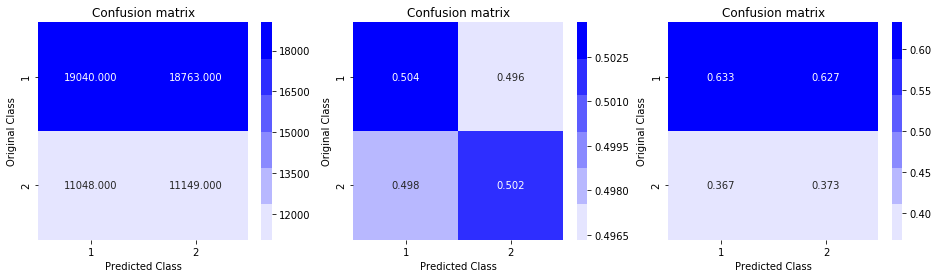

In [142]:
predicted_y=random_model(y_test_tf,model_summary)

In [143]:
print(model_summary)

+--------+-----------------+----------------+
| Model  | Train(Log-Loss) | Test(Log-Loss) |
+--------+-----------------+----------------+
| Random |      0.8848     |     0.8848     |
+--------+-----------------+----------------+


## Logistic Regression:

#### 1.Hyperparam tunning and  loss plot :

for alpha: 0.000010,		 train log-loss: 7.2698,	 cv log-loss: 8.4978
for alpha: 0.000100,		 train log-loss: 6.1089,	 cv log-loss: 7.3266
for alpha: 0.001000,		 train log-loss: 1.6636,	 cv log-loss: 2.2396
for alpha: 0.010000,		 train log-loss: 0.3822,	 cv log-loss: 0.4763
for alpha: 0.100000,		 train log-loss: 0.4101,	 cv log-loss: 0.4508
for alpha: 1.000000,		 train log-loss: 0.5310,	 cv log-loss: 0.5421
for alpha: 10.000000,		 train log-loss: 0.6556,	 cv log-loss: 0.6574
for alpha: 100.000000,		 train log-loss: 0.6905,	 cv log-loss: 0.6907
for alpha: 1000.000000,		 train log-loss: 0.6929,	 cv log-loss: 0.6929
for alpha: 10000.000000,		 train log-loss: 0.6931,	 cv log-loss: 0.6931


optimal alpha:0.100000, log-loss: 0.4508


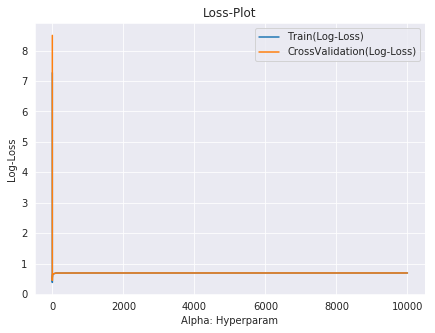

In [144]:
#STANDARDIZING DATA
train, test = std_data(train=stacked_tf_data_train,test=stacked_tf_data_test,mean=False)
#TUNNING HYPERPARAM 
model, opt_train_loss = linear_model_lr(train, y_train_tf, test, y_test_tf, params, CV, search='random')

#### 2.Performance on test data:

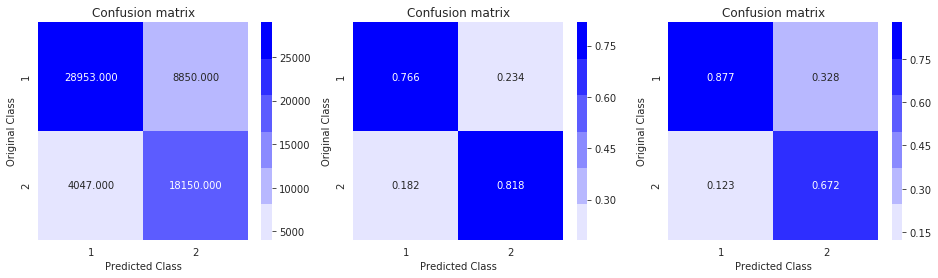

test log-loss: 0.4176


In [145]:
opt_param=model.best_params_['alpha']
test_performance_linear(opt_param, train, y_train_tf, test, y_test_tf, model_summary, opt_train_loss, model_use[0],loss='log')

#### 3. Summary:

In [146]:
print(model_summary)

+---------------------+-----------------+----------------+
|        Model        | Train(Log-Loss) | Test(Log-Loss) |
+---------------------+-----------------+----------------+
|        Random       |      0.8848     |     0.8848     |
| Logistic-Regression |      0.3822     |     0.4176     |
+---------------------+-----------------+----------------+


## Linear SVM

#### 1.Hyperparam tunning and  loss plot :

for alpha: 0.000010,		 train log-loss: 0.4280,	 cv log-loss: 0.4813
for alpha: 0.000100,		 train log-loss: 0.4275,	 cv log-loss: 0.4808
for alpha: 0.001000,		 train log-loss: 0.4245,	 cv log-loss: 0.4787
for alpha: 0.010000,		 train log-loss: 0.3996,	 cv log-loss: 0.4576
for alpha: 0.100000,		 train log-loss: 0.3703,	 cv log-loss: 0.4308
for alpha: 1.000000,		 train log-loss: 0.4031,	 cv log-loss: 0.4402
for alpha: 10.000000,		 train log-loss: 0.4776,	 cv log-loss: 0.4886
for alpha: 100.000000,		 train log-loss: 0.4841,	 cv log-loss: 0.4919
for alpha: 1000.000000,		 train log-loss: 0.4841,	 cv log-loss: 0.4919
for alpha: 10000.000000,		 train log-loss: 0.4841,	 cv log-loss: 0.4919


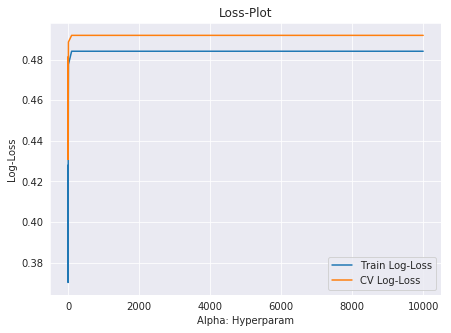

In [147]:
opt_param, opt_train_loss = linear_model_svm(train, y_train_tf, test, y_test_tf, params)

#### 2.Performance on test data:

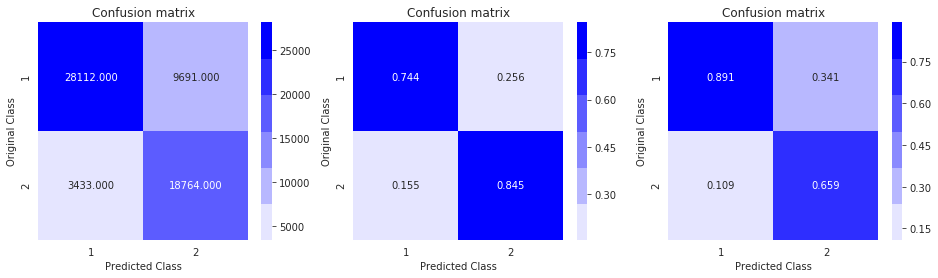

test log-loss: 0.4196


In [148]:
test_performance_linear(opt_param, train, y_train_tf, test, y_test_tf, model_summary, opt_train_loss, model_use[1], loss='hinge')

#### 2. summary:

In [149]:
print(model_summary)

+---------------------+-----------------+----------------+
|        Model        | Train(Log-Loss) | Test(Log-Loss) |
+---------------------+-----------------+----------------+
|        Random       |      0.8848     |     0.8848     |
| Logistic-Regression |      0.3822     |     0.4176     |
|      Linear-SVM     |      0.3703     |     0.4196     |
+---------------------+-----------------+----------------+


## XGBOOST:

### Initialize common objects:

In [37]:
#DICT OF PARAMETERS TO BE TUNED, INITIALLY SET RESONABLE VALUES FOR PARAMETER
params_={
    'n_estimators':128,
    'max_depth':5,
    'min_child_weight':1,
    'gamma':0,
    'subsample':.8,
    'colsample_bytree':.8,
    'reg_alpha':.1
}

#SEARCH METHOD
searchMethod='random'
#TRAIN AND TEST DATA
train=X_train;test=X_test;

#### [a.] Tune n_estimators(no. of base learners):

In [42]:
%%time
#BASE ESTIMATOR RANGE
tune_param={}
tune_param['n_estimators']=[64,128,256]

#TUNNING HYPERPARAM
model=Ensemble_Classifier(train,y_train,CV,params_, tune_param,searchMethod,param_name=1)

#UPDATE OTIMAL VALUE OF PARAMETER
params_['n_estimators'] = model.best_params_['n_estimators']

Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  30 | elapsed:  3.1min remaining:  3.6min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  6.0min finished


Train Log-Loss: 0.3344 CV Log-Loss: 0.3532
Train Log-Loss: 0.2962 CV Log-Loss: 0.3417
Train Log-Loss: 0.2441 CV Log-Loss: 0.3363


#### Test Performance:

test_loss: 0.33175645515301455


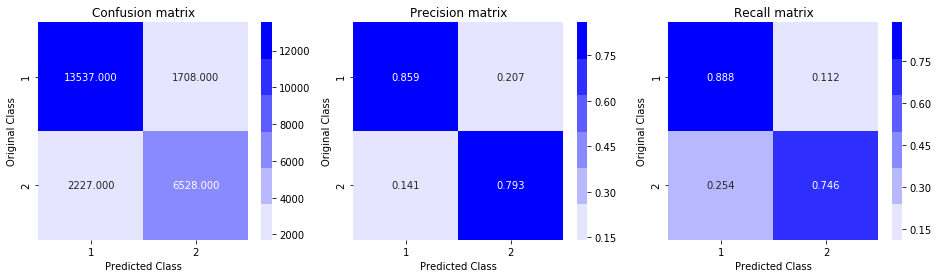

In [46]:
%time test_performance(train, y_train, test, y_test, params_ )

#### [b.] Tune max_depth and min_child_weight:

In [48]:
%%time
#HYPERPARAM RANGE
tune_param={}
tune_param['max_depth']=[5,7,9]
tune_param['min_child_weight']=[1,3,5]

#TUNNING HYPERPARAM
model=Ensemble_Classifier(train, y_train, CV, params_, tune_param, searchMethod, param_name=2)
 
#UPDATE OTIMAL VALUE OF PARAMETER
params_['max_depth'] = model.best_params_['max_depth']
params_['min_child_weight'] = model.best_params_['min_child_weight']

Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  30 | elapsed:  6.6min remaining:  7.5min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 13.5min finished


Train Log-Loss: 0.2441 CV Log-Loss: 0.3363
Train Log-Loss: 0.2482 CV Log-Loss: 0.3367
Train Log-Loss: 0.0645 CV Log-Loss: 0.3394


#### Test Performance:

test_loss: 0.33175645515301455


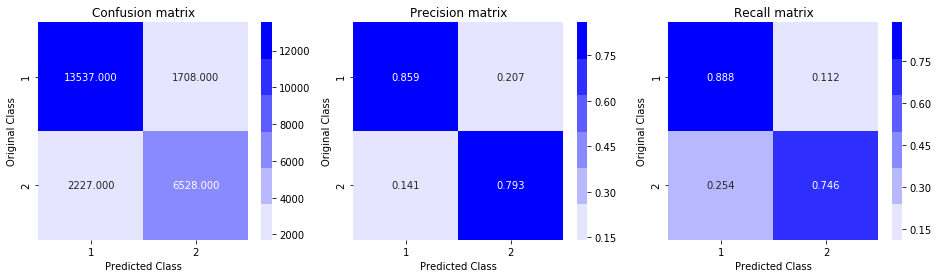

CPU times: user 4min 15s, sys: 2.35 s, total: 4min 17s
Wall time: 4min 14s


In [49]:
%time test_performance(train, y_train, test, y_test,params_ )

#### [c.] Tune gamma:

In [52]:
#HYPERPARAM RANGE
tune_param={}
tune_param['gamma']=[i/10.0 for i in range(0,5)]

#TUNNING HYPERPARAM
model=Ensemble_Classifier(train,y_train,CV,params_,tune_param,searchMethod, param_name=1)

#UPDATE OTIMAL VALUE OF PARAMETER
params_['gamma'] = model.best_params_['gamma']

Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  30 | elapsed:  6.6min remaining:  7.6min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 10.3min finished


Train Log-Loss: 0.2445 CV Log-Loss: 0.3362
Train Log-Loss: 0.2441 CV Log-Loss: 0.3363
Train Log-Loss: 0.2440 CV Log-Loss: 0.3362


#### Test Performance:

test_loss: 0.33178602452932426


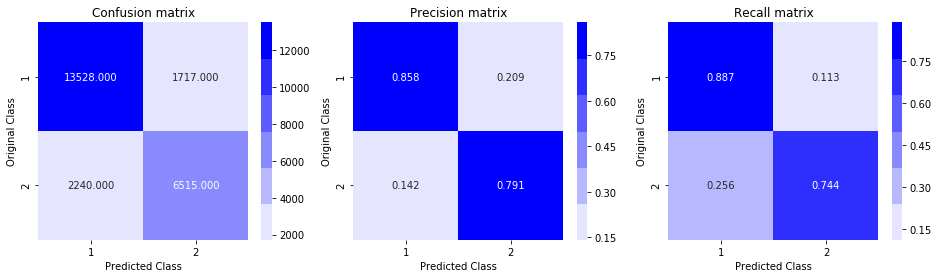

In [53]:
test_performance(train, y_train, test, y_test,params_ )

#### [d.] Tune subsample and colsample_bytree:

In [57]:
%%time
#HYPERPARAM RANGE
tune_param={}
tune_param['subsample']=[.7,.8,.9]#[i/10.0 for i in range(6,10)],
tune_param['colsample_bytree']=[.7,.8,.9]#[i/10.0 for i in range(6,10)]

#TUNNING HYPERPARAM
model=Ensemble_Classifier(train,y_train,CV,params_,tune_param,searchMethod, param_name=2)

#UPDATE OTIMAL VALUE OF PARAMETER
params_['subsample'] = model.best_params_['subsample']
params_['colsample_bytree'] = model.best_params_['colsample_bytree']

Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  30 | elapsed:  7.5min remaining:  8.6min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 11.6min finished


Train Log-Loss: 0.2450 CV Log-Loss: 0.3360
Train Log-Loss: 0.2434 CV Log-Loss: 0.3367
Train Log-Loss: 0.2434 CV Log-Loss: 0.3366
CPU times: user 4min 43s, sys: 1.39 s, total: 4min 45s
Wall time: 16min 16s


#### Test Performance:

test_loss: 0.33225498789842156


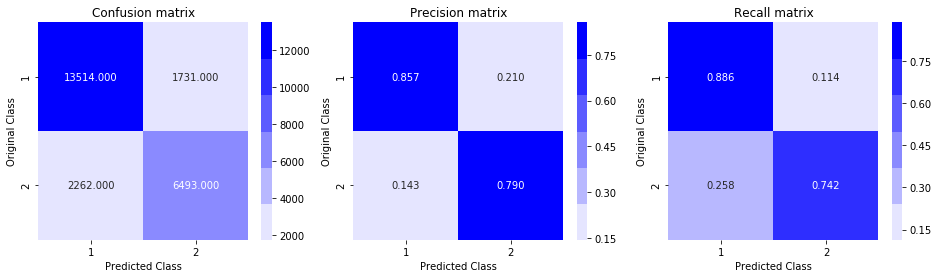

In [58]:
test_performance(train, y_train, test, y_test,params_ )

#### [e.] Tune reg_alpha:

In [59]:
#HYPERPARAM RANGE
tune_param={}
tune_param['reg_alpha']=[0, 0.001, 0.005, 0.01, 0.05]

#TUNNING HYPERPARAM
model=Ensemble_Classifier(train,y_train,CV,params_,tune_param,searchMethod, param_name=1)

#UPDATE OTIMAL VALUE OF PARAMETER
params_['reg_alpha'] = model.best_params_['reg_alpha']

Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  30 | elapsed:  7.7min remaining:  8.8min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 11.9min finished


Train Log-Loss: 0.2455 CV Log-Loss: 0.3359
Train Log-Loss: 0.2447 CV Log-Loss: 0.3360
Train Log-Loss: 0.2452 CV Log-Loss: 0.3359


#### Test Performance:

test_loss: 0.33007172532686385


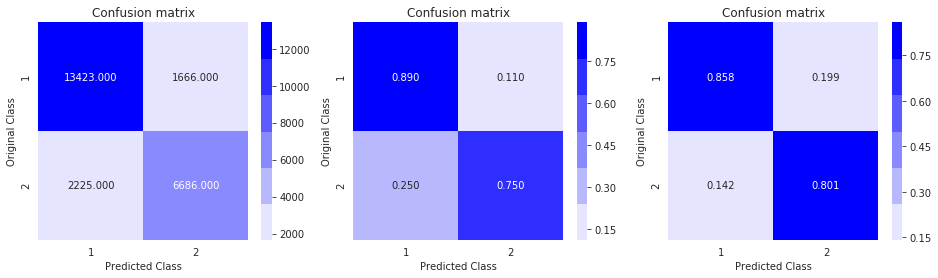

In [154]:
test_performance(train, y_train, test, y_test, params_, model_use[2],True)

#### Summary:

In [155]:
print(model_summary)

+---------------------+-----------------+----------------+
|        Model        | Train(Log-Loss) | Test(Log-Loss) |
+---------------------+-----------------+----------------+
|        Random       |      0.8848     |     0.8848     |
| Logistic-Regression |      0.3822     |     0.4176     |
|      Linear-SVM     |      0.3703     |     0.4196     |
|       XGBoost       |      0.2561     |     0.3301     |
+---------------------+-----------------+----------------+


#### Save final optimal model:

In [151]:
saveModeltofile(model,'XGBOOST_TUNED_MODEL')
model=openModelfromfile('XGBOOST_TUNED_MODEL')
train=X_train;test=X_test;

# Conclusion:

In [156]:
print(model_summary)

+---------------------+-----------------+----------------+
|        Model        | Train(Log-Loss) | Test(Log-Loss) |
+---------------------+-----------------+----------------+
|        Random       |      0.8848     |     0.8848     |
| Logistic-Regression |      0.3822     |     0.4176     |
|      Linear-SVM     |      0.3703     |     0.4196     |
|       XGBoost       |      0.2561     |     0.3301     |
+---------------------+-----------------+----------------+


#### XGBOOST performs very well with log-loss:
        a. train log-loss = .2561
        b. test log-loss = .3301

# Procedure:

1. We have to solve problem, given a pair of questions these question are similar or not.
2. We proceed with basic details of dataset like :
    
        a. How many data points?
        b. Is data is balanced or imbalanced?
        c. How many null values are there?
3. We do Exploratory Data Analysis and Feature Extraction :
    
        a. We extract Frequency based features like length of question, frequency of question, number of words in question, word share etc
        b. We extract more advanced features using fuzzywuzzy (ex fuzz-ratio, fuzz-partial-ratio, token-sort-ratio etc)
        c. We did EDA on Extracted fetures (PDF, Violin plot, Histogram etc).
4. We featurize textual data:
        
        a. TF-IDF Weighted Word2VEC (using spacy pretrained GLO-VEC(Global Vectors)) 
        b. TF-IDF Vector (using sklearn)
5. We build different ML Models on extracted features (Textual + Freq Based + FuzzyWuzzy):
    
        a. Logistic Regression(TF-IDF)    
        b. Linear SVM(TF-IDF)    
        c. XGBOOST(TFIDF-W2V)

Reference Links:
1. https://www.appliedaicourse.com/
2. https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
3. https://spacy.io/usage/vectors-similarity
4. https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
5. https://machinelearningmastery.com/tune-number-size-decision-trees-xgboost-python/